# 6LinMod/assump.py

In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

import os
os.chdir('../KocPythonFall2021/inclass/6LinMod/')

In [2]:
data = pd.read_stata('TamingGods.dta')

data.head()
data.describe()
data.columns
#lets check if ethnic fractionalization is correlated with religious repression
data = data[['Religion', 'Ethnic']].dropna()
y = data['Religion']
X = pd.DataFrame(data['Ethnic'])
X['constant'] = 1
myFit = sm.OLS(y, X).fit()

## Linearity
- The dependent variable (y) is assumed to be a linear function of the independent variables (X, features) specified in the model. The specification must be linear in its parameters. Fitting a linear model to data with non-linear patterns results in serious prediction errors, especially out-of-sample (data not used for training the model).

- To detect nonlinearity one can inspect plots of observed vs. predicted values or residuals vs. predicted values. The desired outcome is that points are symmetrically distributed around a diagonal line in the former plot or around a horizontal line in the latter one. In both cases with a roughly constant variance.

- Observing a ‘bowed’ pattern indicates that the model makes systematic errors whenever it is making unusually large or small predictions. When the model contains many features, nonlinearity can also be revealed by systematic patterns in plots of the residuals vs. individual features.

In [3]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

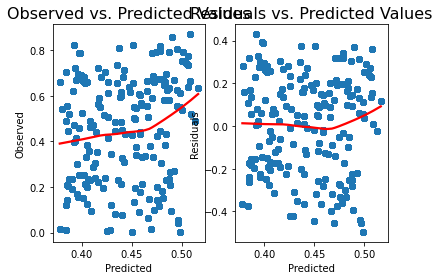

In [4]:
linearity_test(myFit, y)

In [5]:
#expectation of resids is 0 (obviously it is)
myFit.resid.mean()

1.076521696573465e-16

## No Multicollinearity
## Variance Inflation Factor (VIF)
- The square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. If no features are correlated, then all values for VIF will be 1
- To deal with multicollinearity we should iteratively remove features with high values of VIF. A rule of thumb for removal could be VIF larger than 10 (5 is also common). Another possible solution is to use PCA to reduce features to a smaller set of uncorrelated components.

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#we'll need a new model with more covariates
data = pd.read_stata('TamingGods.dta')
data.columns
#lets check if ethnic fractionalization is correlated with religious repression
data = data[['Religion', 'Ethnic', 'polity2_', 'conflict', 'relconflict']].dropna()
y = data['Religion']
X = pd.DataFrame(data[['Ethnic', 'polity2_', 'conflict', 'relconflict']])
X['constant'] = 1
myFit = sm.OLS(y, X).fit()
myFit.summary()
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif[:-1] #no issues

[1.1275758649643688,
 1.1285663381529396,
 1.2432593140139987,
 1.2122957295944514]

## Homoskedasticity
- When residuals do not have constant variance (they exhibit heteroscedasticity), it is difficult to determine the true standard deviation of the forecast errors, usually resulting in confidence intervals that are too wide/narrow. For example, if the variance of the residuals is increasing over time, confidence intervals for out-of-sample predictions will be unrealistically narrow. Another effect of heteroscedasticity might also be putting too much weight to a subset of data when estimating coefficients — the subset in which the error variance was largest.

- To investigate if the residuals are homoscedastic, we can look at a plot of residuals (or standardized residuals) vs. predicted (fitted) values. What should alarm us is the case when the residuals grow either as a function of predicted value or time (in case of time series).

- We can also use two statistical tests: Breusch-Pagan and Goldfeld-Quandt. In both of them, the null hypothesis assumes homoscedasticity and a p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  1.118894e+02
p-value                        2.877208e-23
f-value                        2.864911e+01
f p-value                      1.515523e-23

 Goldfeld-Quandt test ----
                    value
F statistic  1.376585e+00
p-value      1.727374e-14

 Residuals plots ----


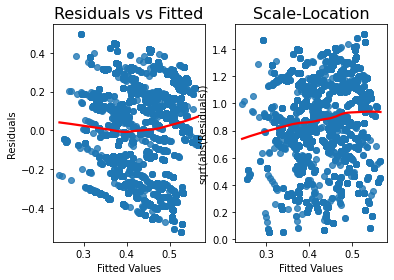

In [7]:
#In the snippets below I plot residuals (and standardized ones) vs. fitted values and carry out the two mentioned tests. To identify homoscedasticity in the plots, the placement of the points should be random and no pattern (increase/decrease in values of residuals) should be visible — the red line in the plots should be flat.

import statsmodels.stats.api as sms
def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(myFit) #very problematic

### Potential solutions:
- transformation of the dependent variable
- in case of time series, deflating a series if it concerns monetary value
- using ARCH (auto-regressive conditional heteroscedasticity) models to model the error variance. An example might be stock market, where data can exhibit periods of increased or decreased volatility over time


## No autocorrelation of residuals

- This assumption is especially dangerous in time-series models, where serial correlation in the residuals implies that there is room for improvement in the model. Extreme serial correlation is often a sign of a badly misspecified model. Another reason for serial correlation in the residuals could be a violation of the linearity assumption or due to bias that is explainable by omitted variables (interaction terms or dummy variables for identifiable conditions). An example of the former case might be fitting a (straight) line to data, which exhibits exponential growth over time.

- This assumption also has meaning in the case of non-time-series models. If residuals always have the same sign under particular conditions, it means that the model systematically underpredicts/overpredicts what happens when the predictors have a particular configuration.

- To investigate if autocorrelation is present, I use ACF (autocorrelation function) plots and Durbin-Watson test.

- In the former case, we want to see if the value of ACF is significant for any lag (in case of no time-series data, the row number is used). While calling the function, we indicate the significance level (see this article for more details) we are interested in and the critical area is plotted on the graph. Significant correlations lie outside of that area.

- Note: when dealing with data without the time dimension, we can alternatively plot the residuals vs. the row number. In such cases, rows should be sorted in a way that (only) depends on the values of the feature(s).

- The second approach is using the Durbin-Watson test. I do not go into detail how it is constructed but provide a high-level overview. The test statistic provides a test for significant residual autocorrelation at lag 1. The DW statistic is approximately equal to 2(1-a), where a is the lag 1 residual autocorrelation. The DW test statistic is located in the default summary output of statsmodels’s regression.

### Some notes on the Durbin-Watson test:
- the test statistic always has a value between 0 and 4
- value of 2 means that there is no autocorrelation in the sample
- values < 2 indicate positive autocorrelation, values > 2 negative one.

C:\Users\MELIHC~1\AppData\Local\Temp/ipykernel_83928/723930087.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


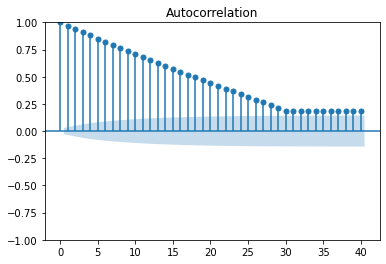

In [8]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(myFit.resid, lags=40 , alpha=0.05)
acf.show()

### Potential solutions:
- in case of minor positive autocorrelation, there might be some room for fine-tuning the model, for example, adding lags of the dependent/independent variables
- some seasonal components might not be captured by the model, account for them using dummy variables or seasonally adjust the variables
- if DW < 1 it might indicate a possible problem in model specification, consider stationarizing time-series variables by differencing, logging, and/or deflating (in case of monetary values)
- in case of significant negative correlation, some of the variables might have been overdifferenced
- use Generalized Least Squares
- include a linear (trend) term in case of a consistent increasing/decreasing pattern in the residuals


### The features and residuals are uncorrelated

- To investigate this assumption I check the Pearson correlation coefficient between each feature and the residuals. Then report the p-value for testing the lack of correlation between the two considered series.


In [9]:
from scipy.stats.stats import pearsonr

for column in X.columns[:-1]:
    corr_test = pearsonr(X[column], myFit.resid)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')
#I cannot reject the null hypothesis (lack of correlation) for any pair.

Variable: Ethnic --- correlation: -0.0000, p-value: 1.0000
Variable: polity2_ --- correlation: 0.0000, p-value: 1.0000
Variable: conflict --- correlation: 0.0000, p-value: 1.0000
Variable: relconflict --- correlation: -0.0000, p-value: 1.0000


In [10]:
#variability in X
X.apply(np.var, axis=0)

Ethnic          0.066601
polity2_       48.881075
conflict        0.155307
relconflict     0.353416
constant        0.000000
dtype: float64

## Normality of residuals

- When this assumption is violated, it causes problems with calculating confidence intervals and various significance tests for coefficients. When the error distribution significantly departs from Gaussian, confidence intervals may be too wide or too narrow.

### Some of the potential reasons causing non-normal residuals:

- presence of a few large outliers in data
- there might be some other problems (violations) with the model assumptions
- another, better model specification might be better suited for this problem


- Technically, we can omit this assumption if we assume instead that the model equation is correct and our goal is to estimate the coefficients and generate predictions (in the sense of minimizing mean squared error).
- However, normally we are interested in making valid inferences from the model or estimating the probability that a given prediction error will exceed some threshold in a particular direction. To do so, the assumption about the normality of residuals must be satisfied.

### To investigate this assumption we can look at:

- QQ plots of the residuals (a detailed description can be found here). For example, a bow-shaped pattern of deviations from the diagonal implies that the residuals have excessive skewness (i.e., the distribution is not symmetrical, with too many large residuals in one direction). The s-shaped pattern of deviations implies excessive kurtosis of the residuals — there are either too many or two few large errors in both directions.
- use statistical tests such as the Kolmogorov-Smirnov test, the Shapiro-Wilk test, the Jarque-Bera test, and the Anderson-Darling test

In [11]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')

Jarque-Bera test ---- statistic: 207.6489, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9696, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.3345, p-value: 0.0000
Anderson-Darling test ---- statistic: 43.6970, 5% critical value: 0.7860
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


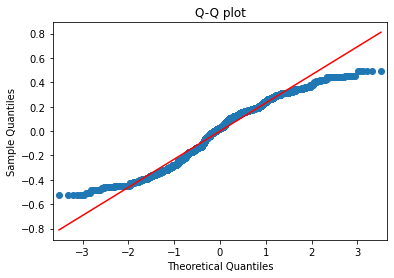

In [12]:
normality_of_residuals_test(myFit)

### Potential solutions:

- nonlinear transformation of target variable or features
- remove/treat potential outliers
- it can happen that there are two or more subsets of the data having different statistical properties, in which case separate models might be considered

In [13]:
#lack of outliers is not an assumption, but outliers may change results, and including/removing/treating needs to be considered in a theoretical fashion
outMat = myFit.outlier_test()
any(outMat['bonf(p)'] < .05)

False

# 7GLMs/glm.py

In [14]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

import os
os.chdir('../7GLMs/')

In [15]:
#!pip install pyreadstat

In [16]:
#below will error, because of the version of stata (you may run into this)
#data = pd.read_stata('repdata.dta')
import pyreadstat
data, meta = pyreadstat.read_dta('repdata.dta')
data.columns

Index(['ccode', 'country', 'cname', 'cmark', 'year', 'wars', 'war', 'warl',
       'onset', 'ethonset', 'durest', 'aim', 'casename', 'ended', 'ethwar',
       'waryrs', 'pop', 'lpop', 'polity2', 'gdpen', 'gdptype', 'gdpenl',
       'lgdpenl1', 'lpopl1', 'region', 'western', 'eeurop', 'lamerica',
       'ssafrica', 'asia', 'nafrme', 'colbrit', 'colfra', 'mtnest', 'lmtnest',
       'elevdiff', 'Oil', 'ncontig', 'ethfrac', 'ef', 'plural', 'second',
       'numlang', 'relfrac', 'plurrel', 'minrelpc', 'muslim', 'nwstate',
       'polity2l', 'instab', 'anocl', 'deml', 'empethfrac', 'empwarl',
       'emponset', 'empgdpenl', 'emplpopl', 'emplmtnest', 'empncontig',
       'empolity2l', 'sdwars', 'sdonset', 'colwars', 'colonset', 'cowwars',
       'cowonset', 'cowwarl', 'sdwarl', 'colwarl'],
      dtype='object')

## Binary Outcome

- lets predict war as a function of Oil
- controls: "empgdpenl"  "emplpopl" "empolity2l" (notice the lags)

In [17]:
data['constant'] = 1

### Logit (most common)

In [18]:
modLogit = sm.Logit(data.war, data[['constant', 'Oil', "empgdpenl", "emplpopl", "empolity2l"]], missing = 'drop').fit()
modLogit.summary()

Optimization terminated successfully.
         Current function value: 0.337281
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    war   No. Observations:                 6192
Model:                          Logit   Df Residuals:                     6187
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.1593
Time:                        15:19:56   Log-Likelihood:                -2088.4
converged:                       True   LL-Null:                       -2484.0
Covariance Type:            nonrobust   LLR p-value:                6.198e-170
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -5.9364      0.268    -22.130      0.000      -6.462      -5.411
Oil            0.4827      0.125      3.858      0.000       0.238       0.728
empgdpenl     -0.3620      0.023    -15.570      0.000      -0.408      -0.316
emplpopl       0.5323      0.028     19.264      0.000       0.478       0.587
empolity2l     0.0594      0.006      9.260      0.000       0.047       0.072
==============================================================================
"""

### Probit

In [19]:
modProbit = sm.Probit(data.war, data[['constant', 'Oil', "empgdpenl", "emplpopl", "empolity2l"]], missing = 'drop').fit()
modProbit.summary() #notice the different scales

Optimization terminated successfully.
         Current function value: 0.336854
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                    war   No. Observations:                 6192
Model:                         Probit   Df Residuals:                     6187
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.1603
Time:                        15:19:56   Log-Likelihood:                -2085.8
converged:                       True   LL-Null:                       -2484.0
Covariance Type:            nonrobust   LLR p-value:                4.435e-171
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -3.5261      0.147    -23.954      0.000      -3.815      -3.238
Oil            0.2546      0.069      3.672      0.000       0.119       0.390
empgdpenl     -0.1828      0.011    -16.820      0.000      -0.204      -0.161
emplpopl       0.3108      0.015     20.085      0.000       0.280       0.341
empolity2l     0.0325      0.004      9.044      0.000       0.025       0.039
==============================================================================
"""

### c-log-log (very uncommon)

In [20]:
cloglog = sm.families.links.cloglog()
modCLL = sm.GLM(data.war, data[['constant', 'Oil', "empgdpenl", "emplpopl", "empolity2l"]], missing = 'drop', family = sm.families.Binomial(cloglog)).fit()
modCLL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    war   No. Observations:                 6192
Model:                            GLM   Df Residuals:                     6187
Model Family:                Binomial   Df Model:                            4
Link Function:                cloglog   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2092.4
Date:                Tue, 30 Nov 2021   Deviance:                       4184.8
Time:                        15:19:56   Pearson chi2:                 5.92e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1188
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -5.2195      0.219    -23.884      0.000      -5.648      -4.791
Oil            0.4247      0.106      3.991      0.000       0.216       0.633
empgdpenl     -0.3239      0.021    -15.596      0.000      -0.365      -0.283
emplpopl       0.4351      0.021     20.330      0.000       0.393       0.477
empolity2l     0.0529      0.005      9.731      0.000       0.042       0.064
==============================================================================
"""

## Counts

- lets predict number of wars as a function of democracy

### Poisson

In [21]:
modPois = sm.Poisson(data.wars, data[['constant', 'empolity2l', 'empgdpenl', 'emplpopl', 'ethfrac', 'relfrac']], missing = 'drop').fit()
modPois.summary()

Optimization terminated successfully.
         Current function value: 0.383406
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                   wars   No. Observations:                 6192
Model:                        Poisson   Df Residuals:                     6186
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.1599
Time:                        15:19:56   Log-Likelihood:                -2374.1
converged:                       True   LL-Null:                       -2825.7
Covariance Type:            nonrobust   LLR p-value:                4.909e-193
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -5.4802      0.211    -25.935      0.000      -5.894      -5.066
empolity2l     0.0253      0.005      5.080      0.000       0.016       0.035
empgdpenl     -0.2182      0.019    -11.553      0.000      -0.255      -0.181
emplpopl       0.4054      0.019     21.389      0.000       0.368       0.443
ethfrac        0.9906      0.120      8.232      0.000       0.755       1.226
relfrac       -0.4396      0.170     -2.585      0.010      -0.773      -0.106
==============================================================================
"""

### Negative Binomial (for overdispersed)

In [22]:
modNB = sm.NegativeBinomial(data.wars, data[['constant', 'empolity2l', 'empgdpenl', 'emplpopl', 'ethfrac', 'relfrac']], missing = 'drop').fit() #notice the warning
modNB = sm.NegativeBinomial(data.wars, data[['constant', 'empolity2l', 'empgdpenl', 'emplpopl', 'ethfrac', 'relfrac']], missing = 'drop').fit(maxiter = 1000) #still - cannot trust results from NB in this example

         Current function value: 0.383423
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
         Current function value: 0.383405
         Iterations: 46
         Function evaluations: 125
         Gradient evaluations: 113


C:\Users\melihcanyardi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\melihcanyardi\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2651: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\melihcanyardi\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2651: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\melihcanyardi\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\melihcanyardi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimi

## Multiple Categories

- lets predict region by ethnic frac

### Logistic Multinomial

In [23]:
import statsmodels.discrete as smd
modMN = smd.discrete_model.MNLogit(data.region, data[['constant', 'ethfrac', 'gdptype']], missing = 'drop').fit()
modMN.summary()

Optimization terminated successfully.
         Current function value: 1.481805
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 region   No. Observations:                 6383
Model:                        MNLogit   Df Residuals:                     6368
Method:                           MLE   Df Model:                           10
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.1540
Time:                        15:19:57   Log-Likelihood:                -9458.4
converged:                       True   LL-Null:                       -11181.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
  region=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -2.0496      0.102    -20.022      0.000      -2.250      -1.849
ethfrac        2.3324      0.225     10.386      0.000       1.892       2.773
gdptype        0.6972      0.039     17.970      0.000       0.621       0.773
------------------------------------------------------------------------------
  region=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -2.2214      0.096    -23.203      0.000      -2.409      -2.034
ethfrac        4.4612      0.197     22.622      0.000       4.075       4.848
gdptype        0.6273      0.036     17.195      0.000       0.556       0.699
------------------------------------------------------------------------------
  region=5       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.8391      0.077    -10.915      0.000      -0.990      -0.688
ethfrac        0.6271      0.211      2.968      0.003       0.213       1.041
gdptype        0.4666      0.036     13.117      0.000       0.397       0.536
------------------------------------------------------------------------------
  region=6       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -2.9665      0.111    -26.739      0.000      -3.184      -2.749
ethfrac        7.2459      0.212     34.107      0.000       6.830       7.662
gdptype        0.1028      0.042      2.423      0.015       0.020       0.186
------------------------------------------------------------------------------
  region=7       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.1748      0.066     -2.667      0.008      -0.303      -0.046
ethfrac        0.5914      0.190      3.116      0.002       0.219       0.963
gdptype        0.1288      0.036      3.541      0.000       0.058       0.200
==============================================================================
"""

### Ordered Logistic Regression
- just for illustration, we'll repeat the number of wars, but this is inappropriate because it is theoretically unbounded

In [24]:
#need dev version of statsmodels
#!pip install git+https://github.com/statsmodels/statsmodels

In [25]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
#modOL = OrderedModel(data.wars, data[['constant', 'empolity2l', 'empgdpenl', 'emplpopl', 'ethfrac', 'relfrac']], missing = 'drop', distr = 'logit').fit()
modOL = OrderedModel(data.wars, data[['empolity2l', 'empgdpenl', 'emplpopl', 'ethfrac', 'relfrac']], missing = 'drop', distr = 'logit').fit()

C:\Users\melihcanyardi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Quasibinomial Regression for Proportions
- predict ethnic frac as a function of polity

In [26]:
modQB = sm.GLM(data.ethfrac, data[['constant', 'empolity2l']], family = sm.families.Binomial(), missing = 'drop').fit()

### TODO: look through https://www.statsmodels.org/stable/examples/index.html and run an atypical glm (e.g., zero-inflated for wars)